In [109]:
import numpy as np
import pandas as pd

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score

RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE)

# Credit Card Dataset

In [3]:
raw_data = pd.read_csv("creditcard.csv")

In [122]:
X = raw_data.drop(columns=["Class"])
y = raw_data["Class"].copy()

inliers = X[y==0]
outliers = X[y==1]
outlier_ratio = len(outliers) / len(X)

# Test samples of non-anomalous class are the same size as outliers
test_ratio = outlier_ratio
splitter = ShuffleSplit(n_splits=1, test_size=test_ratio)

for train_index,test_index in splitter.split(inliers):
    inlier_train = inliers.iloc[train_index]
    inlier_test = inliers.iloc[test_index]

# scaler = StandardScaler()

# inlier_train = scaler.fit_transform(inlier_train)
# inlier_test = scaler.transform(inlier_test)
# outliers = scaler.transform(outliers)

In [62]:
%%time
GMM = GaussianMixture()
GMM.fit(inlier_train)

CPU times: user 1.5 s, sys: 97.5 ms, total: 1.6 s
Wall time: 465 ms


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=1, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [59]:
print("Training Likelihood: {:.3f}".format(GMM.score(inlier_train)))

Training Likelihood: -40.531


## Seems to be overfitting to training data

In [60]:
print("Testing Likelihood: {:.3f}".format(GMM.score(inlier_test)))
print("Outlier Likelihood: {:.3f}".format(GMM.score(outliers)))

Testing Likelihood: -39.882
Outlier Likelihood: -1647.196


In [61]:
print("Testing BIC: {:.3f}".format(GMM.bic(inlier_test)))
print("Outlier BIC: {:.3f}".format(GMM.bic(outliers)))

Testing BIC: 4541053.869
Outlier BIC: 1623909.042


## This is weighted probability of each sample occuring from this distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1fc12c88>]],
      dtype=object)

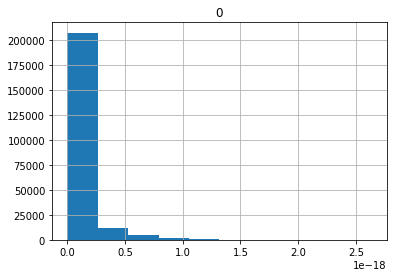

In [51]:
scores = pd.DataFrame(np.exp(GMM.score_samples(inlier_train)))
scores.hist()

In [29]:
preds = pd.Series(GMM.predict(inlier_test))
preds.value_counts()

0    56863
dtype: int64

In [31]:
probs = pd.DataFrame(GMM.predict_proba(inlier_test))
probs.mean()

0    1.0
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e79dcc0>]],
      dtype=object)

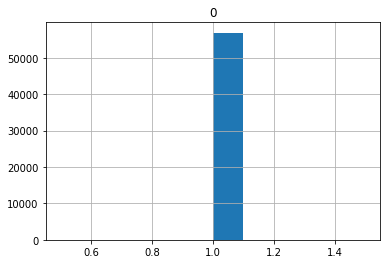

In [32]:
probs.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a20e17ac8>]],
      dtype=object)

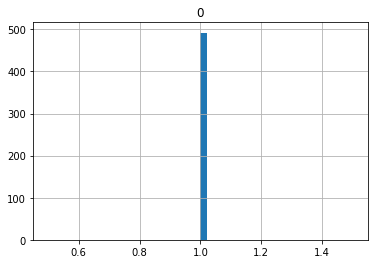

In [50]:
outlier_probs = pd.DataFrame(GMM.predict_proba(outliers))
outlier_probs.hist(bins=50)

## Gridsearch to get better density estimation...

In [63]:
%%time
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(inlier_train)
        bic.append(gmm.bic(inlier_train))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

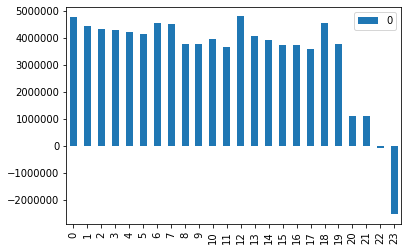

In [65]:
bics = pd.DataFrame(bic)
bics.plot(kind="bar")

In [123]:
%%time
best_gmm = GaussianMixture(n_components=3, covariance_type="full")
best_gmm.fit(inlier_train)

CPU times: user 26.9 s, sys: 1.41 s, total: 28.3 s
Wall time: 7.24 s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [124]:
print("Training Likelihood: {:.3f}".format(best_gmm.score(inlier_train)))
print("Testing Likelihood: {:.3f}".format(best_gmm.score(inlier_test)))
print("Outlier Likelihood: {:.3f}".format(best_gmm.score(outliers)))

Training Likelihood: 0.823
Testing Likelihood: -0.743
Outlier Likelihood: -274.558


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a323ee3c8>,
      dtype=object)

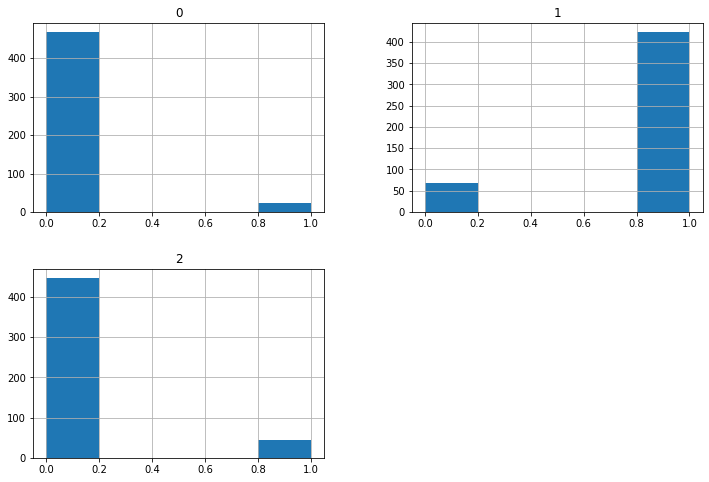

In [125]:
outlier_probs = pd.DataFrame(best_gmm.predict_proba(outliers))
outlier_probs.hist(bins=5, figsize=(12,8))

## Recall that score samples returns probability *densities*
> In order to use them we have to integrate from 0 to x

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2fb04ef0>]],
      dtype=object)

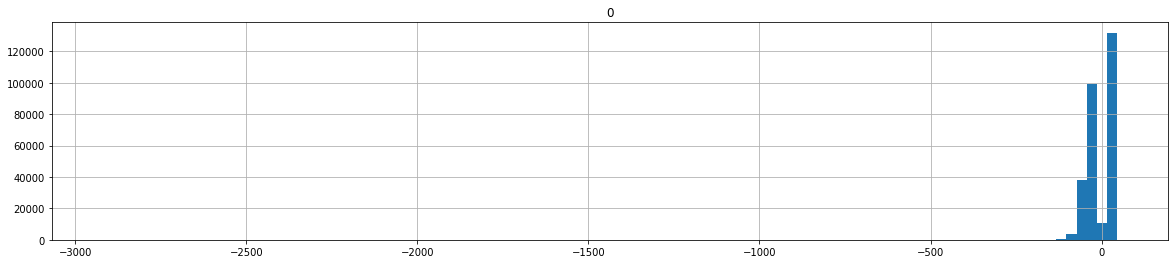

In [126]:
train_scores = pd.DataFrame(best_gmm.score_samples(inlier_train))
train_scores.hist(bins=100, figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a32ef4a20>]],
      dtype=object)

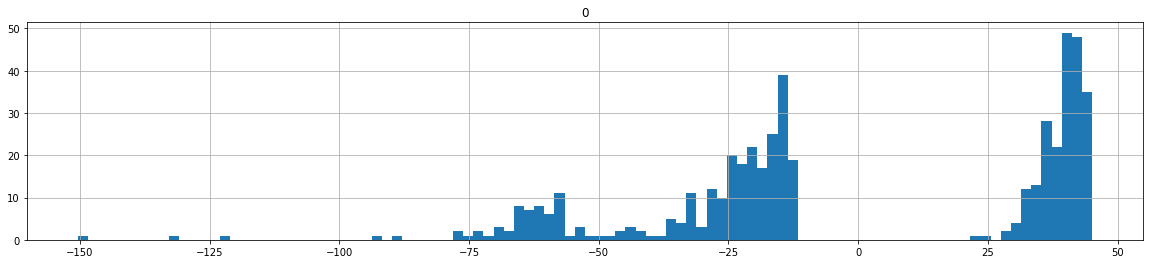

In [127]:
test_scores = pd.DataFrame(best_gmm.score_samples(inlier_test))
test_scores.hist(bins=100, figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a32ef4c88>]],
      dtype=object)

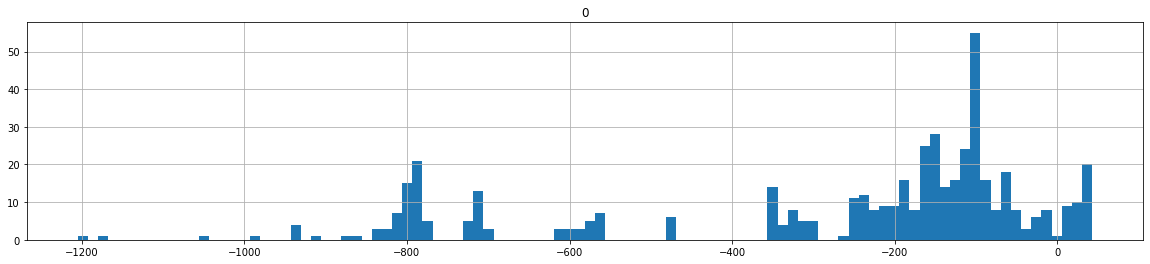

In [128]:
epsilon = 1e-10
outlier_scores = pd.DataFrame(best_gmm.score_samples(outliers))
outlier_scores.hist(bins=100, figsize=(20,4))

## Using Average Precision to test different thresholds

In [129]:
# thresh = inlier_test.mean() + inlier_test.std()*3
y_score = np.concatenate((test_scores, outlier_scores))
y_true = np.concatenate(([0]*len(test_scores), [1]*len(outlier_scores)))

average_precision_score(y_true, y_score)

0.3137928530365953